# Descriptive Analysis - v.1.0

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys
import os
path_project = '/home/igorcosta/PycharmProjects/football/'
sys.path.insert(1, path_project)

from core.config_loader import Config
datasets_path = Config.path('datasets')
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings('ignore')

#### Reading the dataframe

In [2]:
dataset_id = 'sm_accum_odds'
file_path = os.path.join(Config.path('datasets'), dataset_id, 'final.csv')
df = pd.read_csv(file_path)

#### Removing matches without bookmaker odds

In [3]:
df = df[df['odds_p_mean_home'].notna()]
df = df[df['odds_p_mean_draw'].notna()]
df = df[df['odds_p_mean_away'].notna()]

#### Defining list of features

In [4]:
trends_list = ['goals', 'corners', 'on_target', 'off_target', 'attacks', 'dangerous_attacks']
cards_list = ['yellow_cards', 'red_cards']
ratio_list = ['possession']
total_list = trends_list + cards_list + ratio_list

#### Transforming the result a integer number
Home Team - 1 | Draw - 2 | Away Team - 3

In [5]:
df['result_t'] = np.where(df['result']=='H', 1, np.where(df['result'] == 'D', 2, 3))

# EXPERIMENT 01 - Evaluating the features individually

### Preprocessing the dataframes

In [6]:
pred = pd.DataFrame()
pred['id'] = df.index
pred.index = pred['id']
pred['result_t'] = df['result_t']

hits = pd.DataFrame()
hits['id'] = df.index
hits.index = hits['id']
hits['result_t'] = df['result_t']

for t in trends_list:
    for i in range(0,96):
        col_home = '_'.join(['accum_trends',t,'home', str(i)])
        col_away = '_'.join(['accum_trends',t,'away', str(i)])
        col = '_'.join([t,str(i)])
        pred[col] = np.where(df[col_home]>df[col_away],1, np.where(df[col_home]==df[col_away], 2, 3))
        hits[col] = pred[col] == pred['result_t']
        

for t in cards_list:
    for i in range(0,96):
        col_home = '_'.join(['accum_cards',t,'home', str(i)])
        col_away = '_'.join(['accum_cards',t,'away', str(i)])
        col = '_'.join([t,str(i)])
        pred[col] = np.where(df[col_home]<df[col_away],1, np.where(df[col_home]==df[col_away], 2, 3))
        hits[col] = pred[col] == pred['result_t']
        
for t in ratio_list:
    for i in range(0,96):
        col_home = '_'.join(['ratio_trends',t, str(i)])
        col = '_'.join([t,str(i)])
        pred[col] = np.where(df[col_home]>0.5,1, np.where(df[col_home]==0.5, 2, 3))
        hits[col] = pred[col] == pred['result_t']
        
pred_normal = pred
hits_normal = hits

In [7]:
pred = pd.DataFrame()
pred['id'] = df.index
pred.index = pred['id']
pred['result_t'] = df['result_t']

hits = pd.DataFrame()
hits['id'] = df.index
hits.index = hits['id']
hits['result_t'] = df['result_t']

for t in trends_list:
    for i in range(0,96):
        col_home = '_'.join(['accum_trends',t,'home', str(i)])
        col_away = '_'.join(['accum_trends',t,'away', str(i)])
        col = '_'.join([t,str(i)])
        pred[col] = np.where(df[col_home]>=df[col_away],1,3)
        hits[col] = pred[col] == pred['result_t']
        
for t in cards_list:
    for i in range(0,96):
        col_home = '_'.join(['accum_cards',t,'home', str(i)])
        col_away = '_'.join(['accum_cards',t,'away', str(i)])
        col = '_'.join([t,str(i)])
        pred[col] = np.where(df[col_home]<df[col_away],1,3)
        hits[col] = pred[col] == pred['result_t']
        
for t in ratio_list:
    for i in range(0,96):
        col_home = '_'.join(['ratio_trends',t, str(i)])
        col = '_'.join([t,str(i)])
        pred[col] = np.where(df[col_home]>=0.5,1,3)
        hits[col] = pred[col] == pred['result_t']
        
pred_hf = pred
hits_hf = hits

In [8]:
def get_resume(df_hits):
    
    resume = pd.DataFrame()
    total_list = trends_list + cards_list + ratio_list
    for t in total_list:
        hits = list()
        for i in range(0,96):
            col_hit = '_'.join([t,str(i)])
            resume.loc[i,t] = len(df_hits[df_hits[col_hit] == True])/len(df_hits)
    return resume

try:
    resume_normal = pd.read_csv('resume_normal.csv')
    resume_hf = pd.read_csv('resume_hf.csv')
        
except:
    resume_normal = get_resume(hits_normal)
    resume_hf = get_resume(hits_hf)
    resume_normal.to_csv('resume_normal.csv')
    resume_hf.to_csv('resume_hf.csv')

# Experiment 1-A - Predicting from each feature separately 

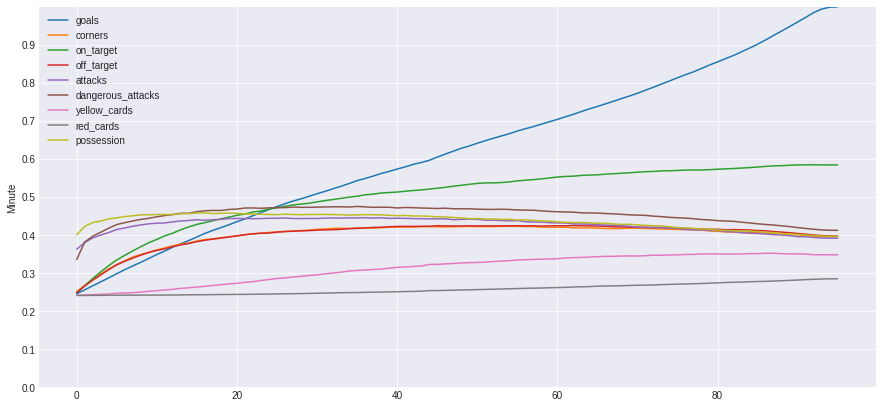

In [9]:
fig = plt.figure(figsize=(15, 7))
for t in total_list:
    plt.plot(resume_normal[t], label=t)
plt.legend(total_list)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.ylabel('Minute')
yticks = np.arange(0,1,0.1)
plt.yticks(yticks)
plt.show()

# Experiment 1-B: Adding 'Home Factor'

We know that in football the home team usually wins more than the visitor. Thus, when the accumulated frequency is equal for both teams, we can predict win of home team, instead of a draw. 

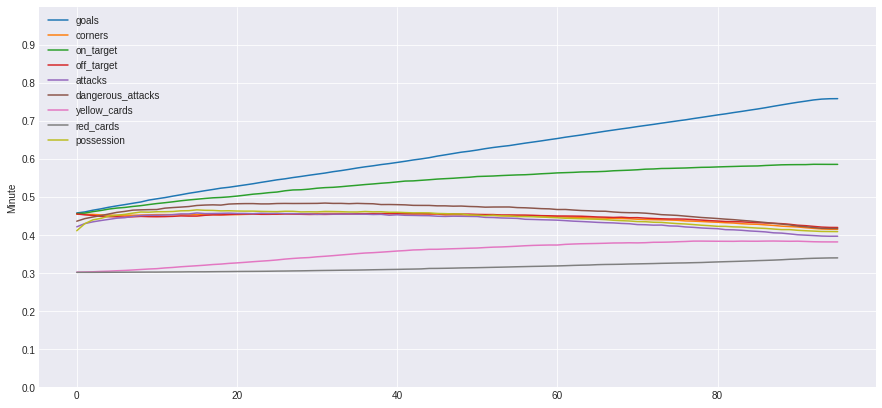

In [10]:
fig = plt.figure(figsize=(15, 7))
for t in total_list:
    plt.plot(resume_hf[t], label=t)
plt.legend(total_list)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.ylabel('Minute')
yticks = np.arange(0,1,0.1)
plt.yticks(yticks)
plt.show()

### Comparing two Approaches

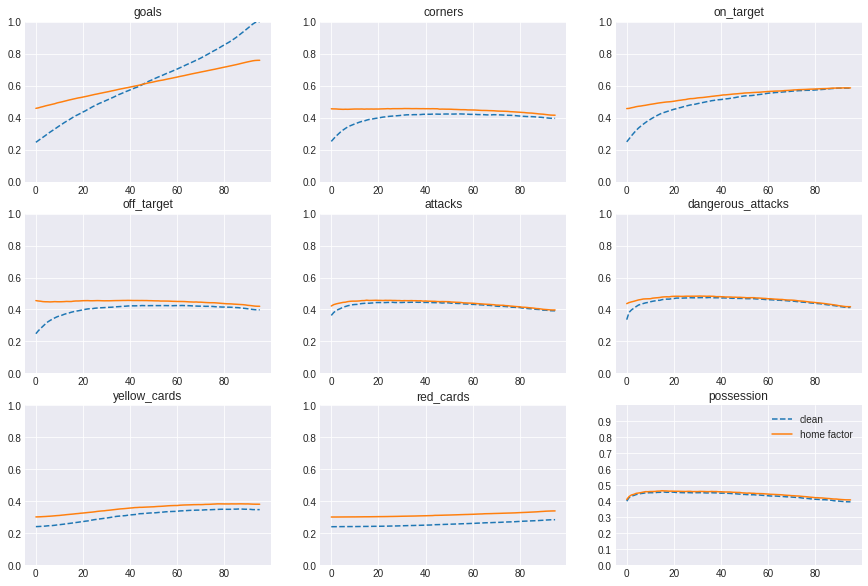

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axs = [item for sublist in axes for item in sublist]

for ax, t in zip(axs, total_list):
    ax.plot(resume_normal[t], label=t, linestyle='--', axes=ax)
    ax.plot(resume_hf[t], label=t, linestyle='-', axes=ax)
    ax.set_title(t)
    ax.set_ylim(0,1)
    
plt.legend(['clean', 'home factor'])
yticks = np.arange(0,1,0.1)
plt.yticks(yticks)
plt.show()

# EXPERIMENT 02 - Analyzing draws 1-1

#### Preprocessing Dataframe

In [12]:
def count_result(df_count, row):
    if row['result'] == 'H':
        df_count['h'] += 1
    elif row['result'] == 'D':
        df_count['d'] += 1
    elif row['result'] == 'A':
        df_count['a'] += 1

In [13]:
try:
    df_exp2 = pd.read_csv('df_exp2.csv')
except:
    df_exp2 = pd.DataFrame()
    
    for j in range(0,96):

        print(j, end=' ')
        home = 0
        away = 0

        home_first = {'h': 0, 'd': 0, 'a': 0}
        away_first = {'h': 0, 'd': 0, 'a': 0}

        col_home = '_'.join(['accum_trends_goals_home', str(j)])
        col_away = '_'.join(['accum_trends_goals_away', str(j)])
        exp = df[(df[col_home] == 1) & (df[col_away] == 1)]

        for row_tuple in exp.iterrows():
            row = row_tuple[1]
            for i in range(0,j):
                col_home_i = '_'.join(['accum','trends','goals', 'home', str(i)])
                col_away_i = '_'.join(['accum','trends','goals', 'away', str(i)])
                if row[col_home_i] == 1:
                    home +=1
                    count_result(home_first, row)
                    break
                elif row[col_away_i] == 1:
                    away +=1
                    count_result(away_first, row)
                    break

        first_win = home_first['h'] + away_first['a']
        draw = home_first['d'] + away_first['d']
        second_win = home_first['a'] + away_first['h']
        
        
        p_value = round(stats.binom_test(first_win, first_win+second_win, p=0.5), 4)
        p_value_home = round(stats.binom_test(home_first['h'], home_first['h']+home_first['a'], p=0.5), 4)
        p_value_away = round(stats.binom_test(away_first['a'], away_first['h']+away_first['a'], p=0.5), 4)

        df_exp2.loc[j,'total'] = len(exp)

        df_exp2.loc[j,'first_win'] = first_win
        df_exp2.loc[j,'draw'] = draw
        df_exp2.loc[j,'second_win'] = second_win
        df_exp2.loc[j,'p_value'] = p_value

        df_exp2.loc[j,'h_first_win'] = home_first['h']
        df_exp2.loc[j,'h_draw'] = home_first['d']
        df_exp2.loc[j,'h_second_win'] = home_first['a']
        df_exp2.loc[j,'h_p_value'] = p_value_home

        df_exp2.loc[j,'a_first_win'] = away_first['a']
        df_exp2.loc[j,'a_draw'] = away_first['d']
        df_exp2.loc[j,'a_second_win'] = away_first['h']
        df_exp2.loc[j,'a_p_value'] = p_value_away
        
    df_exp2.to_csv('df_exp2.csv')

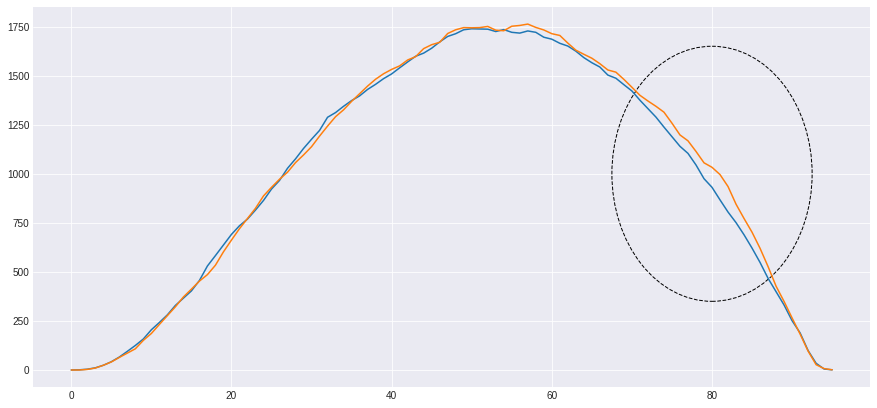

p-value first vs second:  0.8520019283185323


In [14]:
from matplotlib.patches import Ellipse
obs = Ellipse((80, 1000), 25,1300, linestyle='--', fill=False)

fig = plt.figure(figsize=(15, 7))
plt.plot(df_exp2['first_win'])
plt.plot(df_exp2['second_win'])
plt.gcf().gca().add_artist(obs)
plt.show()

print('p-value first vs second: ', stats.ttest_ind(df_exp2['first_win'], df_exp2['second_win']).pvalue)

#### Binomial Test Minute by Minute

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', df.shape[1]):
    display(df_exp2[['total', 'first_win', 'draw', 'second_win', 'p_value']])
    #print(df_exp1[['total', 'h_first_win', 'h_draw', 'h_second_win', 'h_p_value']])
    #print(df_exp1[['total', 'a_first_win', 'a_draw', 'a_second_win', 'a_p_value']])

,total,first_win,draw,second_win,p_value
0,0.0,0.0,0.0,0.0,1.0000
1,2.0,1.0,0.0,0.0,1.0000
2,10.0,4.0,2.0,3.0,1.0000
3,28.0,11.0,6.0,10.0,1.0000
4,62.0,24.0,13.0,24.0,1.0000
5,103.0,42.0,20.0,41.0,1.0000
6,164.0,66.0,34.0,64.0,0.9302
7,237.0,95.0,56.0,86.0,0.5522
8,303.0,125.0,68.0,108.0,0.2945
9,401.0,158.0,92.0,151.0,0.7329


# EXPERIMENT 03 - Analyzing 2-1

### Preprocessing dataframe

In [16]:
try:
    df_exp3 = pd.read_csv('df_exp3.csv')
except Exception:
    df_exp3 = pd.DataFrame()
    for j in range(0,96):

        print(j, end=' ')
        home = {'turned':0 , 'balanced': 0, 'reaction': 0}
        away = {'turned':0 , 'balanced': 0, 'reaction': 0}

        home_winning_turned = {'h': 0, 'd': 0, 'a': 0}
        home_winning_balanced = {'h': 0, 'd': 0, 'a': 0}
        home_winning_reaction = {'h': 0, 'd': 0, 'a': 0}

        away_winning_turned = {'h': 0, 'd': 0, 'a': 0}
        away_winning_balanced = {'h': 0, 'd': 0, 'a': 0}
        away_winning_reaction = {'h': 0, 'd': 0, 'a': 0}

        col_home = '_'.join(['accum','trends','goals', 'home', str(j)])
        col_away = '_'.join(['accum','trends','goals', 'away', str(j)])
        exp2a = df[(df[col_home] == 2) & (df[col_away] == 1)]
        exp2b = df[(df[col_home] == 1) & (df[col_away] == 2)]

        for row_tuple in exp2a.iterrows():

            row = row_tuple[1]
            for i in range(0,j):
                col_home = '_'.join(['accum','trends','goals', 'home', str(i)])
                col_away = '_'.join(['accum','trends','goals', 'away', str(i)])

                if row[col_home] == 1 and row[col_away] == 1:
                    home['balanced'] += 1
                    count_result(home_winning_balanced, row)
                    break

                if row[col_home] == 0 and row[col_away] == 1:
                    home['turned'] += 1
                    count_result(home_winning_turned, row)
                    break

                if row[col_home] == 2 and row[col_away] == 0:
                    home['reaction'] += 1
                    count_result(home_winning_reaction, row)
                    break

        for row_tuple in exp2b.iterrows():

            row = row_tuple[1]
            for i in range(0,j):

                col_home = '_'.join(['accum','trends','goals', 'home', str(i)])
                col_away = '_'.join(['accum','trends','goals', 'away', str(i)])

                if row[col_home] == 1 and row[col_away] == 1:
                    away['balanced'] += 1
                    count_result(away_winning_balanced, row)
                    break

                if row[col_home] == 1 and row[col_away] == 0:
                    away['turned'] += 1
                    count_result(away_winning_turned, row)
                    break

                if row[col_home] == 0 and row[col_away] == 2:
                    away['reaction'] += 1
                    count_result(away_winning_reaction, row)
                    break

        turned_total = home['turned'] + away['turned']
        turned_winning = home_winning_turned['h'] + away_winning_turned['a']
        turned_draw = home_winning_turned['d'] + away_winning_turned['d']
        turned_loosing = home_winning_turned['a'] + away_winning_turned['h']

        balanced_total = home['balanced'] + away['balanced']
        balanced_winning = home_winning_balanced['h'] + away_winning_balanced['a']
        balanced_draw = home_winning_balanced['d'] + away_winning_balanced['d']
        balanced_loosing = home_winning_balanced['a'] + away_winning_balanced['h']

        reaction_total = home['reaction'] + away['reaction']
        reaction_winning = home_winning_reaction['h'] + away_winning_reaction['a']
        reaction_draw = home_winning_reaction['d'] + away_winning_reaction['d']
        reaction_loosing = home_winning_reaction['a'] + away_winning_reaction['h']

        pop_balanced = balanced_winning*[0] + balanced_draw*[1] + balanced_loosing*[2]
        pop_turned = turned_winning*[0] + turned_draw*[1] + turned_loosing*[2]
        pop_reaction = reaction_winning*[0] + reaction_draw*[1] + reaction_loosing*[2]

        prop_balanced = [balanced_winning, balanced_draw, balanced_loosing]
        prop_turned = [turned_winning, turned_draw, turned_loosing]
        prop_reaction = [reaction_winning, reaction_draw, reaction_loosing]
        
        p_balanced_reaction = stats.chisquare(prop_balanced, prop_reaction)
        p_balanced_turned = stats.chisquare(prop_balanced, prop_turned)
        p_turned_reaction = stats.chisquare(prop_turned, prop_reaction)

        df_exp3.loc[j,'turned_total'] = turned_total
        df_exp3.loc[j,'turned_winning'] = turned_winning
        df_exp3.loc[j,'turned_draw'] = turned_draw
        df_exp3.loc[j,'turned_loosing'] = turned_loosing

        df_exp3.loc[j,'balanced_total'] = balanced_total
        df_exp3.loc[j,'balanced_winning'] = balanced_winning
        df_exp3.loc[j,'balanced_draw'] = balanced_draw
        df_exp3.loc[j,'balanced_loosing'] = balanced_loosing

        df_exp3.loc[j,'reaction_total'] = reaction_total
        df_exp3.loc[j,'reaction_winning'] = reaction_winning
        df_exp3.loc[j,'reaction_draw'] = reaction_draw
        df_exp3.loc[j,'reaction_loosing'] = reaction_loosing

        df_exp3.loc[j,'p_balanced_reaction'] = round(p_balanced_reaction.pvalue,5)
        df_exp3.loc[j,'p_balanced_turned'] = round(p_balanced_turned.pvalue,5)
        df_exp3.loc[j,'p_turned_reaction'] = round(p_turned_reaction.pvalue,5)

    df_exp3.to_csv('df_exp3.csv')

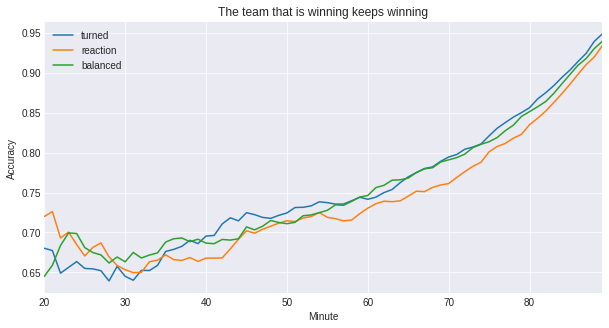

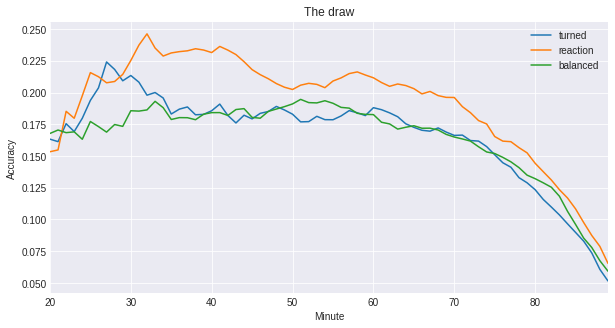

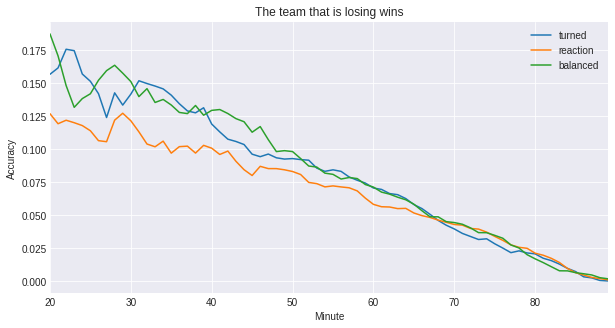

In [17]:
def plot_df(turned_df,reaction_df,balanced_df, title):
    begin = 20
    end = 90
    turned_df[begin:end].plot()
    reaction_df[begin:end].plot()
    balanced_df[begin:end].plot()
    plt.legend(['turned','reaction','balanced'])
    plt.ylabel("Accuracy")
    plt.xlabel("Minute")
    plt.title(title)

fig = plt.figure(figsize=(10,5))
turned_w = df_exp3['turned_winning']/df_exp3['turned_total']
reaction_w = df_exp3['reaction_winning']/df_exp3['reaction_total']
balanced_w = df_exp3['balanced_winning']/df_exp3['balanced_total']

plot_df(turned_w, reaction_w, balanced_w, 'The team that is winning keeps winning')

fig = plt.figure(figsize=(10,5))
turned_d = df_exp3['turned_draw']/df_exp3['turned_total']
reaction_d = df_exp3['reaction_draw']/df_exp3['reaction_total']
balanced_d = df_exp3['balanced_draw']/df_exp3['balanced_total']

plot_df(turned_d, reaction_d, balanced_d, 'The draw')

fig = plt.figure(figsize=(10,5))
turned_l = df_exp3['turned_loosing']/df_exp3['turned_total']
reaction_l = df_exp3['reaction_loosing']/df_exp3['reaction_total']
balanced_l = df_exp3['balanced_loosing']/df_exp3['balanced_total']

plot_df(turned_l, reaction_l, balanced_l, 'The team that is losing wins')

#### Chi-Squared Test By Minute

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', df.shape[1]):
    display(df_exp3[['p_balanced_reaction','p_balanced_turned','p_turned_reaction']])
    #print(df_exp3[['turned_total', 'turned_winning', 'turned_draw', 'turned_loosing']])
    #print(df_exp2[['balanced_total', 'balanced_winning', 'balanced_draw', 'balanced_loosing']])
    #print(df_exp2[['reaction_total', 'reaction_winning', 'reaction_draw', 'reaction_loosing']])
    #print(df_exp1[['total', 'a_first_win', 'a_draw', 'a_second_win', 'a_p_value']])

,p_balanced_reaction,p_balanced_turned,p_turned_reaction
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,0.00000,NaN,NaN
8,0.00000,0.00000,NaN
9,0.00000,0.00000,NaN


# EXPERIMENT 04 - Analyzing time difference between the third and fourth goals.

#### Preprocessing

In [19]:
def get_minutes(row, winning):
    
    m1, m2, m3, m4 = 0, 0, 0, 0 
    
    selection = 'other'
    for i in range(0,96):

        col_home = '_'.join(['accum','trends','goals', 'home', str(i)])
        col_away = '_'.join(['accum','trends','goals', 'away', str(i)])
        
        if row[col_home] == 0 and row[col_away] == 1 and m1 == 0 and winning == 'H':
            selection = 'turned'
            m1 = i

        elif row[col_home] == 1 and row[col_away] == 0 and m1 == 0 and winning == 'A':
            selection = 'turned'
            m1 = i
            
        elif row[col_home] == 1 and row[col_away] == 1 and m2 == 0:
            if selection != 'turned':
                selection = 'balanced'
            m2 = i 
            
        elif row[col_home] == 0 and row[col_away] == 2 and m2 == 0:
            selection = 'reaction'              
            m2 = i 
        
        elif row[col_home] == 2 and row[col_away] == 0 and m2 == 0:
            selection = 'reaction'              
            m2 = i
            
        elif row[col_home] == 1 and row[col_away] == 2 and m3 == 0:    
            m3 = i 
            
        elif row[col_home] == 2 and row[col_away] == 1 and m3 == 0:
            m3 = i 
        
        elif row[col_home] == 2 and row[col_away] == 2 and m4 == 0:
            m4 = i 
            break
            
    if m4 == 0:
        selection = 'other'
        
    return m1, m2, m3, m4, selection
            
try:
    df_goals_time = pd.read_csv('2_1_goals_time.csv')
except Exception:
    
    goals_time = []
    inserted = []
    
    for j in range(0,96):

        print(j, end=' ')

        col_home = '_'.join(['accum','trends','goals', 'home', str(j)])
        col_away = '_'.join(['accum','trends','goals', 'away', str(j)])
        exp3a = df[(df[col_home] == 2) & (df[col_away] == 1) & ((df['result'] == 'D') | (df['result'] == 'A'))]
        exp3b = df[(df[col_home] == 1) & (df[col_away] == 2) & ((df['result'] == 'H') | (df['result'] == 'D'))]
        for row_tuple in exp3a.iterrows():

            row = row_tuple[1]
            
            if row_tuple[0] not in inserted:
                m1, m2, m3, m4, selection = get_minutes(row,'H')
                goals_time.append({'m1': m1, 'm2': m2, 'm3': m3, 'm4': m4, 'selection': selection})
                inserted.append(row_tuple[0])       

        for row_tuple in exp3b.iterrows():

            row = row_tuple[1]
            
            if row_tuple[0] not in inserted:
                break
            else:
                m1, m2, m3, m4, selection = get_minutes(row, 'A')
                goals_time.append({'m1': m1, 'm2': m2, 'm3': m3, 'm4': m4,'selection': selection})
                inserted.append(row_tuple[0])   
    
    df_goals_time = pd.DataFrame(goals_time)          
    df_goals_time.to_csv('2_1_goals_time.csv') 

In [20]:
balanced_dd = df_goals_time[df_goals_time['selection']=='balanced']
dif_balanced_23 = balanced_dd['m3']-balanced_dd['m2']
dif_balanced_34 = balanced_dd['m4']-balanced_dd['m3']

turned_dd = df_goals_time[df_goals_time['selection']=='turned']
dif_turned_23 = turned_dd['m3']-turned_dd['m2']
dif_turned_34 = turned_dd['m4']-turned_dd['m3']

reaction_dd = df_goals_time[df_goals_time['selection']=='reaction']
dif_reaction_23 = reaction_dd['m3']-reaction_dd['m2']
dif_reaction_34 = reaction_dd['m4']-reaction_dd['m3']

print("Number of balanced matches: ", len(balanced_dd))
print("Number of turned matches: ", len(turned_dd))
print("Number of reaction matches: ", len(reaction_dd))

print("Minutes for balanced matches: ", dif_balanced_34.mean())
print("Minutes for turned matches ", dif_turned_34.mean())
print("Minutes for reaction matches", dif_reaction_34.mean())

#print(stats.ttest_ind(dif_balanced_23,dif_balanced_34))
#print(stats.ttest_ind(dif_turned_23,dif_turned_34))
#print(stats.ttest_ind(dif_reaction_23,dif_reaction_34))

p_balanced_turned = stats.ttest_ind(dif_balanced_34,dif_turned_34).pvalue
p_balanced_reaction = stats.ttest_ind(dif_balanced_34,dif_reaction_34).pvalue
p_turned_reaction = stats.ttest_ind(dif_turned_34,dif_reaction_34).pvalue

print("p-value balanced vs turned: ", p_balanced_turned)
print("p-value balanced vs reaction: ", p_balanced_reaction)
print("p-value turned vs turned: ", p_turned_reaction)

Number of balanced matches:  571
Number of turned matches:  579
Number of reaction matches:  651
Minutes for balanced matches:  17.949211908931698
Minutes for turned matches  17.385146804835923
Minutes for reaction matches 17.45468509984639
p-value balanced vs turned:  0.47071664186072115
p-value balanced vs reaction:  0.5384840014052135
p-value turned vs turned:  0.9287617517057443


# EXPERIMENT 05 - Analyzing the influence of early red cards.

#### Prepocessing Dataframe

In [21]:
try:
    df_exp5 = pd.read_csv('df_exp5.csv') 
except:
    df_exp5 = pd.DataFrame()
    
    col_home = '_'.join(['accum','cards','red_cards', 'home', str(95)])
    col_away = '_'.join(['accum','cards','red_cards', 'away', str(95)])

    df_exp5 = pd.DataFrame(columns=['benefited','draw','punished'])
    df_exp5['minute'] = range(96)
    df_exp5.set_index('minute', inplace=True)
    df_exp5.fillna(0, inplace=True)

    df_exp5a = df[(df[col_home] == 1) & (df[col_away] == 0)]
    df_exp5b = df[(df[col_home] == 0) & (df[col_away] == 1)]

    for row_tuple in df_exp5a.iterrows():

        row = row_tuple[1]

        for i in range(0,96):
            col_home = '_'.join(['accum','cards','red_cards', 'home', str(i)])
            col_away = '_'.join(['accum','cards','red_cards', 'away', str(i)])

            if row[col_home] == 1:
                if row['result'] == 'H':
                    df_exp5.loc[i,'punished'] += 1
                elif row['result'] == 'D':
                    df_exp5.loc[i,'draw'] += 1
                elif row['result'] == 'A':
                    df_exp5.loc[i,'benefited'] += 1
                break

    for row_tuple in df_exp5b.iterrows():

        row = row_tuple[1]

        for i in range(0,96):
            col_home = '_'.join(['accum','cards','red_cards', 'home', str(i)])
            col_away = '_'.join(['accum','cards','red_cards', 'away', str(i)])

            if row[col_away] == 1:
                if row['result'] == 'H':
                    df_exp5.loc[i,'benefited'] += 1
                elif row['result'] == 'D':
                    df_exp5.loc[i,'draw'] += 1
                elif row['result'] == 'A':
                    df_exp5.loc[i,'punished'] += 1

                break

    df_exp5.to_csv('df_exp5.csv') 

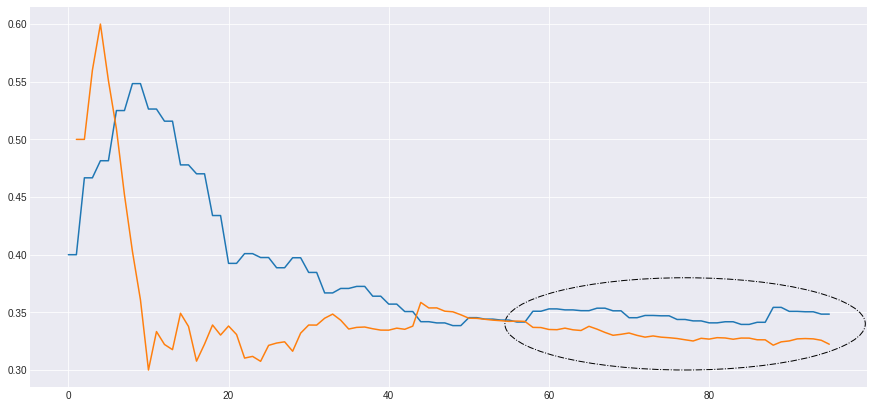

In [22]:
fp_list = []
sp_list = []

frame = []
for j in range(0,96):
    
    i = j/2
    
    fp = df_exp5[df_exp5.index <= i].sum()
    sp = df_exp5[(df_exp5.index > i) & (df_exp5.index <= j)].sum()
    ben_fp = fp['benefited']/fp.sum()
    ben_sp = sp['benefited']/sp.sum()
    
    fp_list.append(ben_fp)
    sp_list.append(ben_sp)
    pvalue = stats.chisquare(fp, sp).pvalue

    
    d = {'minute': j, 'first_part': round(ben_fp, 5), 'second_part': round(ben_sp, 5), 'p_value': round(pvalue, 4)}
    frame.append(d)
  
obs = Ellipse((77, 0.34), 45,0.08, linestyle='-.', fill=False)

fig = plt.figure(figsize=(15,7))
plt.plot(fp_list)
plt.plot(sp_list)
plt.gcf().gca().add_artist(obs)
plt.show()

#### Chi-Squared Test By Minute

In [23]:
res = pd.DataFrame(frame)
res.set_index('minute', inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', df.shape[1]):
    display(res[['first_part', 'second_part', 'p_value']])

,first_part,second_part,p_value
minute,,,
0,0.40000,NaN,NaN
1,0.40000,0.50000,0.1623
2,0.46667,0.50000,0.0216
3,0.46667,0.56000,0.0009
4,0.48148,0.60000,0.0534
5,0.48148,0.55102,0.0014
6,0.52500,0.50909,0.0631
7,0.52500,0.45205,0.0003
8,0.54839,0.40278,0.0027
